# Computer Vision CSCI-GA.2272-001 Assignment 2

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/


## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

- Give a breakdown of the parameters within the above model, and the overall number.

In [157]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

In [167]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64  # input batch size for training
epochs = 10      # number of epochs to train
lr = .001      # learning rate

In [168]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

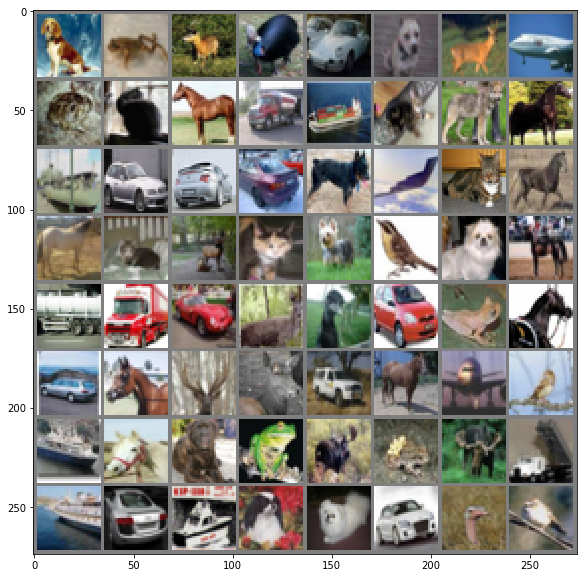

In [163]:
# shows Cifar image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(40, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

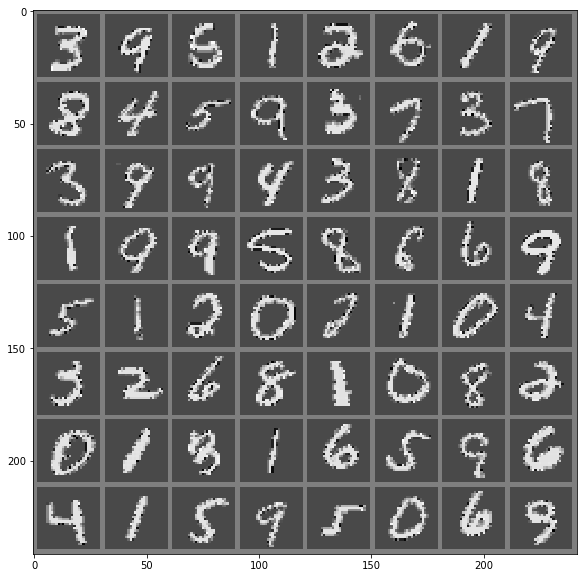

In [166]:
# shows Mnist images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(40,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [169]:
## 1) Regular network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [117]:
## 2) Adding an extra layer with 100 unit hidden  
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
hidden_units = 1000

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_units)
        self.linear2 = nn.Linear(hidden_units, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        input = F.tanh(self.linear1(input)) #adding the tan h 
        output = self.linear2(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [106]:
# 3) limit the dataset to 50 examples 
batch_size = 1
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
# print('The new dataset consist of', len(train_loader), 'training points')
# print(train_loader)


def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0: #log every 10 points
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

        if batch_idx % 50 == 0: #only train for 50 points 
            break  

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [112]:
# 4) conv model network  
num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 128, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(128*5*5, 64)
        self.linear2 = nn.Linear(64, 10)

    def forward(self, input):
        input = self.pool1(F.tanh(self.conv1(input)))
        input = self.pool1(F.tanh(self.conv2(input)))
        input = input.view(-1, 128*5*5)
        input = F.tanh(self.linear1(input))
        output = self.linear2(input)

        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [113]:
params = list(network.parameters())
print('over all number of parameters are', len(params))
print('network structure is', network)
for i, param in enumerate(params):
    print(i, 'th parameter has a length of', params[i].size())


over all number of parameters are 8
network structure is Net (
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (linear1): Linear (3200 -> 64)
  (linear2): Linear (64 -> 10)
)
0 th parameter has a length of torch.Size([16, 3, 5, 5])
1 th parameter has a length of torch.Size([16])
2 th parameter has a length of torch.Size([128, 16, 5, 5])
3 th parameter has a length of torch.Size([128])
4 th parameter has a length of torch.Size([64, 3200])
5 th parameter has a length of torch.Size([64])
6 th parameter has a length of torch.Size([10, 64])
7 th parameter has a length of torch.Size([10])


In [144]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [170]:
# For document/output clarity, I only show the output of the regular-base network. 
# I pasted the output of all other networks in the report.   
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.625756


Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.614594


Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.225168


Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.169835


Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.940284


Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.672165


Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.723844


Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.757564


Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.718328


Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.643243



Test set: Average loss: 0.5934, Accuracy: 8599/10000 (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.505341


Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.462312


Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.720734


Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.536640


Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.673072


Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.464776


Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.653927


Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.399559


Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.586888


Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.445643



Test set: Average loss: 0.4678, Accuracy: 8798/10000 (88%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.499165


Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.605067


Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.572700


Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.421661


Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.602800


Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.396483


Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.430347


Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.546109


Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.528771


Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.466112



Test set: Average loss: 0.4181, Accuracy: 8897/10000 (89%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.725935


Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.379638


Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.293552


Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.509532


Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.413847


Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.678065


Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.426347


Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.513430


Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.465826


Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.691630



Test set: Average loss: 0.3911, Accuracy: 8961/10000 (90%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.520967


Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.338747


Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.206518


Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.372481


Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.400533


Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.320167


Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.475556


Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.293105


Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.379694


Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.353404



Test set: Average loss: 0.3733, Accuracy: 9017/10000 (90%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.401816


Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.429552


Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.389691


Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.301638


Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.384235


Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.298589


Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.556678


Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.440709


Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.413071


Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.294592



Test set: Average loss: 0.3602, Accuracy: 9030/10000 (90%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.593010


Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.426673


Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.442943


Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.464987


Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.494022


Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.406890


Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.243778


Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.397806


Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.477619


Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.263261



Test set: Average loss: 0.3506, Accuracy: 9048/10000 (90%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.274385


Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.226662


Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.383086


Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.360081


Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.345718


Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.566317


Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.251886


Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.250270


Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.259944


Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.284047



Test set: Average loss: 0.3427, Accuracy: 9060/10000 (91%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.298921


Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.243675


Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.391388


Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.470057


Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.339193


Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.305934


Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.358979


Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.258222


Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.373570


Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.254076



Test set: Average loss: 0.3360, Accuracy: 9079/10000 (91%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.362573


Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.473114


Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.631091


Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.388514


Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.309151


Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.372625


Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.411950


Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.183366


Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.603893


Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.299785



Test set: Average loss: 0.3314, Accuracy: 9095/10000 (91%)



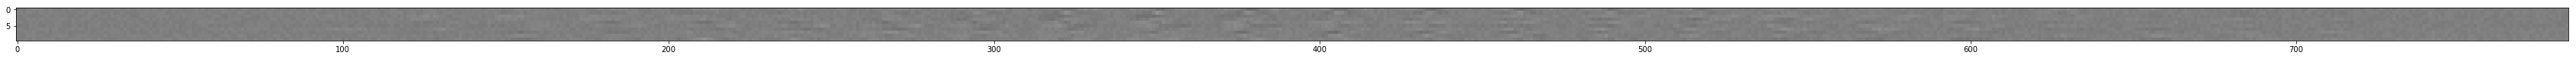

In [156]:
#Visualize network weight 
def visualize_net_weights(network):
    for w in network.modules():
        if isinstance(w, nn.Linear): 
            w = w.weight.data
            imshow(torchvision.utils.make_grid(w))

visualize_net_weights(network)

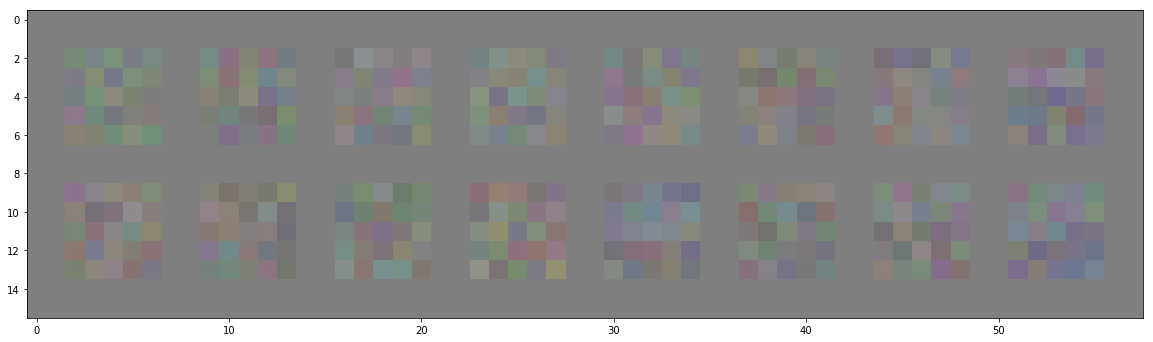

In [18]:
#Visualize first layer conv filter 
def visualize_net_weights(network):
    for w in network.modules():
        if isinstance(w, nn.Conv2d): 
            w = w.weight.data
            imshow(torchvision.utils.make_grid(w))
            break

visualize_net_weights(network)